<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#imports-&amp;-setup" data-toc-modified-id="imports-&amp;-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports &amp; setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#create-full-network" data-toc-modified-id="create-full-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>create full network</a></span></li><li><span><a href="#End-to-end-training-(step-1)" data-toc-modified-id="End-to-end-training-(step-1)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>End-to-end training (step 1)</a></span></li><li><span><a href="#Approx-mean-field-covariance-function-params-(step-2)" data-toc-modified-id="Approx-mean-field-covariance-function-params-(step-2)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Approx mean-field covariance function params (step 2)</a></span></li><li><span><a href="#DGL-Monitoring-(step-3)" data-toc-modified-id="DGL-Monitoring-(step-3)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>DGL Monitoring (step 3)</a></span></li><li><span><a href="#DGL-LEGO-(step-4)" data-toc-modified-id="DGL-LEGO-(step-4)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>DGL LEGO (step 4)</a></span><ul class="toc-item"><li><span><a href="#save-pretrained-layers" data-toc-modified-id="save-pretrained-layers-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>save pretrained layers</a></span></li></ul></li><li><span><a href="#Training-of-the-Linear-Classifier-(step-5)" data-toc-modified-id="Training-of-the-Linear-Classifier-(step-5)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Training of the Linear Classifier (step 5)</a></span><ul class="toc-item"><li><span><a href="#Traing-using-frozen-DGL-trained-layers" data-toc-modified-id="Traing-using-frozen-DGL-trained-layers-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Traing using frozen DGL-trained layers</a></span></li><li><span><a href="#retrain---frozen-random" data-toc-modified-id="retrain---frozen-random-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>retrain - frozen random</a></span></li></ul></li><li><span><a href="#train/val/test-scores" data-toc-modified-id="train/val/test-scores-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>train/val/test scores</a></span></li></ul></div>

# imports & setup

In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

from util.util import zero_mean_labels, balanced_subsample

from functools import partial

from util.exp import (
    weight_init,
    ConvFFNet,
    get_bn_labels_preds,
    get_inputs_labels,
    get_loss,
    get_layer_name,
    get_layer_idx_name_x0,
    update_layer_,
    layer_activations,
    accuracy,
)

from util.kernelutils import (
    BIE_MSE_loss,
    BIE_eps_finder,
    get_MF_params
)

from util.optim import (
    decay_weights,
    TransformsTensorDataset,
)

from sklearn.model_selection import train_test_split

import json

from itertools import cycle
import time

In [2]:
iter_idx=0

# data

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
   ])),
    batch_size=60000,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
   ])),
    batch_size=10000,
)

In [4]:
X_train, labels_train=next(iter(train_loader))

In [5]:
X_test, labels_test=next(iter(test_loader))

In [6]:
X_train = X_train[(labels_train==1) | (labels_train==7)]
labels_train = labels_train[(labels_train==1) | (labels_train==7)]
labels_train = (labels_train == 7).to(torch.int)

In [7]:
X_test = X_test[(labels_test==1) | (labels_test==7)]
labels_test = labels_test[(labels_test==1) | (labels_test==7)]
labels_test = (labels_test == 7).to(torch.int)

In [8]:
n_test_samples = labels_test.shape[0]

In [9]:
n_classes = np.unique(labels_train).shape[0]

In [10]:
n_train_samples=2000
n_valid_samples=2000

In [11]:
np.random.seed(421)

In [12]:
idxs=np.arange(X_train.shape[0])

In [13]:
balanced_idxs = balanced_subsample(pd.Series(labels_train.numpy(), index=idxs))

train_idxs, val_idxs = train_test_split(balanced_idxs, train_size=n_train_samples, test_size=n_valid_samples, stratify=labels_train[balanced_idxs])

In [14]:
X_valid = X_train[val_idxs]
X_train = X_train[train_idxs]

labels_valid = labels_train[val_idxs]
labels_train = labels_train[train_idxs]

In [15]:
labels_train_cat = pd.Categorical(labels_train)

labels_valid_cat = pd.Categorical(labels_valid, categories=labels_train_cat.categories)

labels_test_cat = pd.Categorical(labels_test, categories=labels_train_cat.categories)


display(labels_train_cat.value_counts())

display(labels_valid_cat.value_counts())

display(labels_test_cat.value_counts())


0    1000
1    1000
dtype: int64

0    1000
1    1000
dtype: int64

0    1135
1    1028
dtype: int64

In [16]:
labels_train_cat

[1, 1, 1, 1, 0, ..., 0, 1, 0, 1, 1]
Length: 2000
Categories (2, int64): [0, 1]

# create full network 

In [17]:
device=torch.device('cuda')

In [18]:
train = TransformsTensorDataset(
    X_train.to(dtype=torch.float32), 
    torch.tensor(zero_mean_labels(pd.get_dummies(labels_train_cat).values), dtype=torch.float32),
    device=device,
)
valid = TransformsTensorDataset(
    X_valid.to(dtype=torch.float32), 
    torch.tensor(zero_mean_labels(pd.get_dummies(labels_valid_cat).values), dtype=torch.float32),
    device=device,
)

test = TransformsTensorDataset(
    X_test.to(dtype=torch.float32), 
    torch.tensor(zero_mean_labels(pd.get_dummies(labels_test_cat).values), dtype=torch.float32),
    device=device,
)

In [19]:
trainloader_single = torch.utils.data.DataLoader(
    train, batch_size=1, shuffle=True, drop_last=True)
trainloader_single_iter = cycle(trainloader_single)

In [20]:
# calculate input shapes for defining the net
t=next(trainloader_single_iter)[0]

n_inputs=t.shape[-1]
n_train_samples=t.shape[0]
c_inputs=t.shape[1] if len(t.shape) == 4 else 0

In [21]:
n_h_layers=2
h_h_layers=20

nonlinear=torch.relu
bias=True

bayesian_trained_layers = range(n_h_layers+1)

In [22]:
net = ConvFFNet(
    n_inputs=n_inputs, 
    n_classes=n_classes, 
    n_h_layers=n_h_layers, 
    h_h_layers=h_h_layers,
    nonlinear=nonlinear,
    bias=bias,
).to(device)

In [23]:
print(net)

ConvFFNet(
  (fc_layers): ModuleList(
    (0): ActivatedLinear(
      (module): Linear(in_features=784, out_features=20, bias=True)
    )
    (1): ActivatedLinear(
      (module): Linear(in_features=20, out_features=20, bias=True)
    )
    (2): ActivatedLinear(
      (module): Linear(in_features=20, out_features=20, bias=True)
    )
    (3): Linear(in_features=20, out_features=2, bias=True)
  )
  (layers): ModuleList(
    (0): ActivatedLinear(
      (module): Linear(in_features=784, out_features=20, bias=True)
    )
    (1): ActivatedLinear(
      (module): Linear(in_features=20, out_features=20, bias=True)
    )
    (2): ActivatedLinear(
      (module): Linear(in_features=20, out_features=20, bias=True)
    )
    (3): Linear(in_features=20, out_features=2, bias=True)
  )
)


# End-to-end training (step 1)

In [24]:
for (name,child) in net.layers.named_children(): 
    for param in child.parameters():
        param.requires_grad=True

In [25]:
device=torch.device('cuda')
net.to(device);

In [26]:
optimizer_algo='SGD'

In [27]:
mb_size=50
lr=0.001
weight_decay=0.0005

In [28]:
max_epochs=1000
check_every_epoch=1
full_mb_size = n_valid_samples

In [29]:
train_seed=156

In [30]:
last_epoch=-1

In [31]:
torch.manual_seed(train_seed)
np.random.seed(train_seed)
net.apply(weight_init);

In [32]:
if optimizer_algo == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_algo=='Adam':
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [33]:
trainloader = torch.utils.data.DataLoader(
    train, batch_size=mb_size, shuffle=True, drop_last=True,)
validloader = torch.utils.data.DataLoader(
    valid, batch_size=mb_size, shuffle=True, drop_last=True,)
validloader_iter = cycle(validloader)
trainloader_iter = cycle(trainloader)

trainloader_full = torch.utils.data.DataLoader(
    train, batch_size=full_mb_size, shuffle=True, drop_last=True,)
validloader_full = torch.utils.data.DataLoader(
    valid, batch_size=full_mb_size, shuffle=True, drop_last=True,)
validloader_full_iter = cycle(validloader_full)
trainloader_full_iter = cycle(trainloader_full)

In [34]:
testloader_full = torch.utils.data.DataLoader(
    test, batch_size=n_test_samples, shuffle=True, drop_last=True,)
testloader_full_iter = cycle(testloader_full)

In [35]:
n_epoch_batches = len(train)//mb_size  
n_classes = net.layers[-1].out_features

In [36]:
criterion=nn.MSELoss()
net_outputs_fn=None

In [37]:
#     print(net)
start_time=time.time()
final_ms=[]
print('iter_idx:{} {:.1f}s | start training'.format(iter_idx, time.time() - start_time))

valid_losses=[]
losses=[]
lrs=[]
lr_epochs=[]
try:

    # initial loss before training
    train_inputs, train_labels = next(trainloader_full_iter)
    train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    train_loss=get_loss(criterion, train_labels, train_outputs)
    losses.append((last_epoch,train_loss.item()))
    train_loss = losses[-1][1]
    
    # initial loss before training
    valid_inputs, valid_labels = next(validloader_full_iter)
    valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    valid_loss=get_loss(criterion, valid_labels, valid_outputs)
    valid_losses.append((last_epoch,valid_loss.item()))
    print(
        'Initial | loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
            train_loss, 
            valid_loss,
            accuracy(train_labels, train_outputs),
            accuracy(valid_labels, valid_outputs),
        )
    )
    
    last_epoch+=1
    for epoch in range(last_epoch, max_epochs):  # loop over the datasetset multiple times
        net.train()
        
        for i, local_batch in enumerate(trainloader, 1):#step_iter:
           
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize

            loss = get_loss(
                criterion,
                *get_bn_labels_preds(local_batch, net, device=device, net_outputs_fn=net_outputs_fn)
            )
            
            loss.backward()
            
            optimizer.step()

            
        last_epoch=epoch
        net.eval()
    

        
        if last_epoch % max_epochs == 10:
            check_every_epoch = np.max((10,check_every_epoch))
        if last_epoch % max_epochs == 20:
            check_every_epoch = np.max((20,check_every_epoch))
        if last_epoch % max_epochs == 100:
            check_every_epoch = np.max((100,check_every_epoch))

        if ((last_epoch % max_epochs) == 0) or ((epoch % max_epochs) % check_every_epoch == 0): 
            valid_inputs, valid_labels = next(validloader_full_iter)        
            valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
            valid_loss = get_loss(criterion, valid_labels, valid_outputs)
            valid_losses.append((last_epoch,valid_loss.item()))
            valid_loss = valid_losses[-1][1]

            train_inputs, train_labels = next(trainloader_full_iter)
            train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
            train_loss = get_loss(criterion, train_labels, train_outputs)
            losses.append((last_epoch, train_loss.item()))
            train_loss = losses[-1][1]
            
            print(
                'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
                    iter_idx,
                    time.time() - start_time, 
                    last_epoch, 
                    train_loss, 
                    valid_loss,
                    accuracy(train_labels, train_outputs),
                    accuracy(valid_labels, valid_outputs),
                )
            )


except KeyboardInterrupt:
    last_epoch=epoch+1
    print('iter_idx:{} {:.1f}s | epoch:{}, interupting training, wrapping up'.format(iter_idx, time.time() - start_time, last_epoch))
    net.eval()

valid_inputs, valid_labels = next(validloader_full_iter)
valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
valid_loss = get_loss(criterion, valid_labels, valid_outputs)
valid_losses.append((last_epoch,valid_loss.item()))
valid_loss = valid_losses[-1][1]
final_sgd_valid_loss=valid_loss

train_inputs, train_labels = next(trainloader_full_iter)
train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
train_loss = get_loss(criterion, train_labels, train_outputs)
losses.append((last_epoch, train_loss.item()))
train_loss = losses[-1][1]
final_sgd_loss=train_loss
print(
    'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
        iter_idx,
        time.time() - start_time,
        last_epoch, 
        train_loss, 
        valid_loss,
        accuracy(train_labels, train_outputs),
        accuracy(valid_labels, valid_outputs),
    )
)
final_sgd_acc=accuracy(train_labels, train_outputs)
final_sgd_valid_acc=accuracy(valid_labels, valid_outputs)


test_inputs, test_labels = next(testloader_full_iter)
test_labels, test_outputs = get_bn_labels_preds((test_inputs, test_labels), net, device=device, net_outputs_fn=net_outputs_fn)
final_sgd_test_loss = get_loss(criterion, test_labels, test_outputs).item()
final_sgd_test_acc = accuracy(test_labels, test_outputs)

iter_idx:0 0.0s | start training
Initial | loss: 4.6e+01, valid_loss: 4.7e+01, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.2s | epoch:0, loss: 0.64, valid_loss: 0.69, acc: 71.05, valid_acc: 70.60
iter_idx:0 0.3s | epoch:1, loss: 0.44, valid_loss: 0.49, acc: 78.30, valid_acc: 77.85
iter_idx:0 0.3s | epoch:2, loss: 0.34, valid_loss: 0.39, acc: 82.55, valid_acc: 82.05
iter_idx:0 0.4s | epoch:3, loss: 0.28, valid_loss: 0.32, acc: 85.65, valid_acc: 84.70
iter_idx:0 0.4s | epoch:4, loss: 0.24, valid_loss: 0.28, acc: 87.65, valid_acc: 86.10
iter_idx:0 0.5s | epoch:5, loss: 0.21, valid_loss: 0.25, acc: 89.30, valid_acc: 88.45
iter_idx:0 0.5s | epoch:6, loss: 0.19, valid_loss: 0.23, acc: 90.40, valid_acc: 89.05
iter_idx:0 0.6s | epoch:7, loss: 0.17, valid_loss: 0.21, acc: 91.00, valid_acc: 90.25
iter_idx:0 0.6s | epoch:8, loss: 0.16, valid_loss: 0.2, acc: 92.05, valid_acc: 91.85
iter_idx:0 0.7s | epoch:9, loss: 0.15, valid_loss: 0.18, acc: 92.00, valid_acc: 91.80
iter_idx:0 0.7s | epoch:10, loss:

# Approx mean-field covariance function params (step 2)

In [38]:
K_params_list = []

for n in bayesian_trained_layers:
    K_params_cur = get_MF_params(net.top_net(n+1),act_type="ReLU")
    K_params_list += [np.array(K_params_cur)**2]

# DGL Monitoring (step 3)

In [39]:
device=torch.device('cuda')
net.to(device)

BIE_device=torch.device('cpu')
BIE_dtype=torch.float32

In [40]:
for (name,child) in net.layers.named_children(): 
    for param in child.parameters():
        param.requires_grad=True

In [41]:
last_epoch=-1

In [42]:
torch.manual_seed(train_seed)
np.random.seed(train_seed)
net.apply(weight_init);

In [43]:
if optimizer_algo == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_algo=='Adam':
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [44]:
full_mb_size=2000
BIE_eps_acc=1e-4

In [45]:
trainloader = torch.utils.data.DataLoader(
    train, batch_size=mb_size, shuffle=True, drop_last=True,)
validloader = torch.utils.data.DataLoader(
    valid, batch_size=mb_size, shuffle=True, drop_last=True,)
validloader_iter = cycle(validloader)
trainloader_iter = cycle(trainloader)

trainloader_full = torch.utils.data.DataLoader(
    train, batch_size=full_mb_size, shuffle=True, drop_last=True,)
validloader_full = torch.utils.data.DataLoader(
    valid, batch_size=full_mb_size, shuffle=True, drop_last=True,)
validloader_full_iter = cycle(validloader_full)
trainloader_full_iter = cycle(trainloader_full)

In [46]:
n_epoch_batches = len(train)//mb_size
n_classes = net.layers[-1].out_features

In [47]:
check_every_epoch=1

In [48]:
criterion=nn.MSELoss()
net_outputs_fn=None
BIE_loss_fn=BIE_MSE_loss

In [49]:
start_time=time.time()

print('iter_idx:{} {:.1f}s | start training'.format(iter_idx, time.time() - start_time))

valid_losses=[]
losses=[]

valid_accs=[]
accs=[]

lrs=[]
lr_epochs=[]
try:
    valid_BIE_losses=[]
    train_BIE_losses=[]
    
    # initial loss before training
    train_inputs, train_labels = next(trainloader_full_iter)
    train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    train_loss=get_loss(criterion, train_labels, train_outputs)
    losses.append((last_epoch,train_loss.item()))

    # initial loss before training
    valid_inputs, valid_labels = next(validloader_full_iter)
    valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    valid_loss=get_loss(criterion, valid_labels, valid_outputs)
    valid_losses.append((last_epoch,valid_loss.item()))
    
    valid_BIE_layer_losses=[]
    train_BIE_layer_losses=[]

    BIE_eps=[]
    for layer_idx in bayesian_trained_layers:
        K_params = K_params_list[layer_idx]
        BIE_net_outputs_fn = partial(layer_activations, layer_idx=layer_idx)
        
        train_labels, BIE_train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)
        # find the optimal BIE_eps
        BIE_eps.append(BIE_eps_finder(BIE_train_outputs,K_params,device=BIE_device,acc=BIE_eps_acc))
    
    print('layer_idx, BIE_eps: {}'.format(list(zip(bayesian_trained_layers, BIE_eps))))
    
    for layer_idx in bayesian_trained_layers:
        K_params = K_params_list[layer_idx]
        BIE_net_outputs_fn = partial(layer_activations, layer_idx=layer_idx)
        
        train_labels, BIE_train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)
        
        BIE_criterion=partial(BIE_loss_fn, K_params=K_params, device=BIE_device, dtype=BIE_dtype, eps=BIE_eps[layer_idx],)
        train_BIE_layer_losses.append(
            get_loss(BIE_criterion, train_labels, BIE_train_outputs).item()
        )    
        valid_BIE_layer_losses.append(
            get_loss(BIE_criterion, *get_bn_labels_preds(
                (valid_inputs, valid_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)
            ).item()
        )
        
    print(
        'Initial | loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
            train_loss, 
            valid_loss,
            accuracy(train_labels, train_outputs),
            accuracy(valid_labels, valid_outputs),
        )
    )
    accs.append(accuracy(train_labels, train_outputs))
    valid_accs.append(accuracy(valid_labels, valid_outputs))
    print(
        'train BIE: {}\n'.format(','.join(['{:.2}'.format(bll) for bll in train_BIE_layer_losses])),
        'valid BIE: {}'.format(','.join(['{:.2}'.format(bll) for bll in valid_BIE_layer_losses]))
    )

    train_BIE_losses.append(train_BIE_layer_losses)
    valid_BIE_losses.append(valid_BIE_layer_losses)
    
    last_epoch+=1
    for epoch in range(last_epoch, max_epochs):  # loop over the datasetset multiple times
        running_loss = 0.0
        valid_running_loss = 0.0
#             print('iter_idx:{} {:.1f}s | epoch: {}'.format(iter_idx, time.time() - start_time, epoch))
        net.train()

        for i, local_batch in enumerate(trainloader, 1):#step_iter:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize

            loss = get_loss(
                criterion,
                *get_bn_labels_preds(local_batch, net, device=device, net_outputs_fn=net_outputs_fn)
            )
            
            loss.backward()
            
            optimizer.step()

        last_epoch=epoch
        net.eval()
        
        if last_epoch % max_epochs == 10:
            check_every_epoch = np.max((10,check_every_epoch))
        if last_epoch % max_epochs == 20:
            check_every_epoch = np.max((20,check_every_epoch))
            
        if ((last_epoch % max_epochs) == 0) or ((epoch % max_epochs) % check_every_epoch == 0): 
            valid_inputs, valid_labels = next(validloader_full_iter)        
            valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
            valid_loss = get_loss(criterion, valid_labels, valid_outputs)
            valid_losses.append((last_epoch,valid_loss.item()))
            valid_loss = valid_losses[-1][1]
            

            train_inputs, train_labels = next(trainloader_full_iter)
            train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
            train_loss = get_loss(criterion, train_labels, train_outputs)
            losses.append((last_epoch,train_loss.item()))
            train_loss = losses[-1][1]

            valid_BIE_layer_losses=[]
            train_BIE_layer_losses=[]
            for layer_idx in bayesian_trained_layers:
                K_params = K_params_list[layer_idx]
                BIE_net_outputs_fn = partial(layer_activations, layer_idx=layer_idx)
            
                train_labels, BIE_train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)

                BIE_criterion=partial(BIE_loss_fn, K_params=K_params, device=BIE_device, dtype=BIE_dtype, eps=BIE_eps[layer_idx])
                
                train_BIE_layer_losses.append(
                    get_loss(BIE_criterion, train_labels, BIE_train_outputs).item()
                )
                
                valid_BIE_layer_losses.append(
                    get_loss(BIE_criterion, *get_bn_labels_preds(
                        (valid_inputs, valid_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)
                    ).item()
                )
              
        
            print(
                '{:.1f}s |epoch: {}:, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
                    time.time() - start_time,
                    last_epoch,
                    train_loss, 
                    valid_loss,
                    accuracy(train_labels, train_outputs),
                    accuracy(valid_labels, valid_outputs),
                )
            )
            accs.append(accuracy(train_labels, train_outputs))
            valid_accs.append(accuracy(valid_labels, valid_outputs))
            print(
                'train BIE: {}\n'.format(','.join(['{:.2}'.format(bll) for bll in train_BIE_layer_losses])),
                'valid BIE: {}'.format(','.join(['{:.2}'.format(bll) for bll in valid_BIE_layer_losses]))
            )
            train_BIE_losses.append(train_BIE_layer_losses)
            valid_BIE_losses.append(valid_BIE_layer_losses)

except KeyboardInterrupt:
    last_epoch=epoch+1
    print('iter_idx:{} {:.1f}s | epoch:{}, interupting training, wrapping up'.format(iter_idx, time.time() - start_time, last_epoch))
    net.eval()


valid_inputs, valid_labels = next(validloader_full_iter)
valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
valid_loss = get_loss(criterion, valid_labels, valid_outputs)
valid_losses.append((last_epoch,valid_loss.item()))
valid_loss = valid_losses[-1][1]


train_inputs, train_labels = next(trainloader_full_iter)
train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
train_loss = get_loss(criterion, train_labels, train_outputs)
losses.append((last_epoch,train_loss.item()))
train_loss = losses[-1][1]

valid_BIE_layer_losses=[]
train_BIE_layer_losses=[]

for layer_idx in bayesian_trained_layers:
    K_params = K_params_list[layer_idx]
    BIE_net_outputs_fn = partial(layer_activations, layer_idx=layer_idx)
    train_labels, BIE_train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)

    BIE_criterion=partial(BIE_loss_fn, K_params=K_params, device=BIE_device, dtype=BIE_dtype, eps=BIE_eps[layer_idx])

    train_BIE_layer_losses.append(
        get_loss(BIE_criterion, train_labels, BIE_train_outputs).item()
    )

    valid_BIE_layer_losses.append(
        get_loss(BIE_criterion, *get_bn_labels_preds(
            (valid_inputs, valid_labels), net, device=device, net_outputs_fn=BIE_net_outputs_fn)
        ).item()
    )

print(
    'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
        iter_idx,
        time.time() - start_time,
        last_epoch, 
        train_loss, 
        valid_loss,
        accuracy(train_labels, train_outputs),
        accuracy(valid_labels, valid_outputs),
    )
)
accs.append(accuracy(train_labels, train_outputs))
valid_accs.append(accuracy(valid_labels, valid_outputs))
print(
    'train BIE: {}\n'.format(','.join(['{:.2}'.format(bll) for bll in train_BIE_layer_losses])),
    'valid BIE: {}'.format(','.join(['{:.2}'.format(bll) for bll in valid_BIE_layer_losses]))
)
train_BIE_losses.append(train_BIE_layer_losses)
valid_BIE_losses.append(valid_BIE_layer_losses)

iter_idx:0 0.0s | start training
layer_idx, BIE_eps: [(0, 0.057256323242187504), (1, 0.08003778686523438), (2, 0.11434887695312501)]
Initial | loss: 4.6e+01, valid_loss: 4.7e+01, acc: 50.00, valid_acc: 50.00
train BIE: 0.041,0.068,0.18
 valid BIE: 0.042,0.066,0.18
2.5s |epoch: 0:, loss: 0.64, valid_loss: 0.69, acc: 71.05, valid_acc: 70.60
train BIE: 0.052,0.089,0.22
 valid BIE: 0.053,0.082,0.21
3.6s |epoch: 1:, loss: 0.44, valid_loss: 0.49, acc: 78.30, valid_acc: 77.85
train BIE: 0.051,0.083,0.2
 valid BIE: 0.051,0.079,0.19
4.7s |epoch: 2:, loss: 0.34, valid_loss: 0.39, acc: 82.55, valid_acc: 82.05
train BIE: 0.05,0.077,0.18
 valid BIE: 0.051,0.076,0.18
5.8s |epoch: 3:, loss: 0.28, valid_loss: 0.32, acc: 85.65, valid_acc: 84.70
train BIE: 0.049,0.073,0.16
 valid BIE: 0.05,0.072,0.16
6.9s |epoch: 4:, loss: 0.24, valid_loss: 0.28, acc: 87.65, valid_acc: 86.10
train BIE: 0.048,0.068,0.15
 valid BIE: 0.048,0.069,0.15
8.0s |epoch: 5:, loss: 0.21, valid_loss: 0.25, acc: 89.30, valid_acc: 88.

110.3s |epoch: 960:, loss: 0.0054, valid_loss: 0.02, acc: 99.70, valid_acc: 99.10
train BIE: 0.011,0.011,0.011
 valid BIE: 0.021,0.022,0.026
112.8s |epoch: 980:, loss: 0.0053, valid_loss: 0.02, acc: 99.70, valid_acc: 99.10
train BIE: 0.011,0.011,0.012
 valid BIE: 0.02,0.022,0.026
iter_idx:0 114.7s | epoch:999, loss: 0.0052, valid_loss: 0.02, acc: 99.70, valid_acc: 99.10
train BIE: 0.011,0.011,0.011
 valid BIE: 0.02,0.022,0.026


In [50]:
train_losses_df=pd.concat(
    [
        pd.DataFrame(losses).set_axis(['epoch','train_loss'], axis=1, inplace=False),
        pd.DataFrame(accs, columns=['train_acc']),
        pd.DataFrame(train_BIE_losses).set_axis(
            ['train_BIE_{}'.format(i) for i in bayesian_trained_layers],
            axis=1,
            inplace=False,
        ),
    ],
    axis=1,
).sort_index(axis=1)

valid_losses_df=pd.concat(
    [
        pd.DataFrame(valid_losses).set_axis(['epoch','valid_loss'], axis=1, inplace=False),
        pd.DataFrame(valid_accs, columns=['valid_acc']),
        pd.DataFrame(valid_BIE_losses).set_axis(
            ['valid_BIE_{}'.format(i) for i in bayesian_trained_layers],
            axis=1,
            inplace=False,
        ),
    ],
    axis=1,
).sort_index(axis=1)

<IPython.core.display.Javascript object>


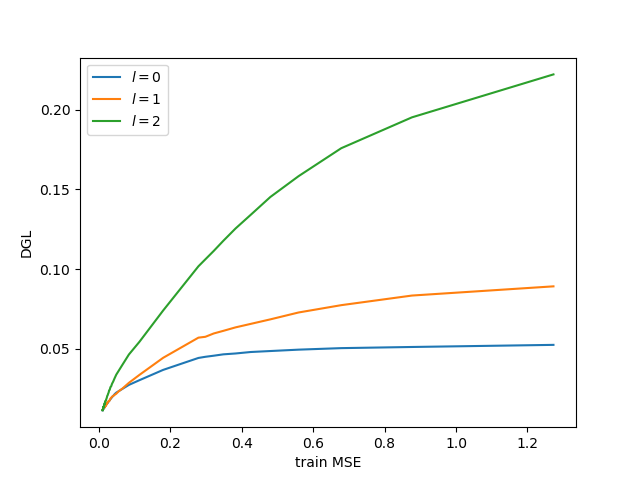

<IPython.core.display.Javascript object>


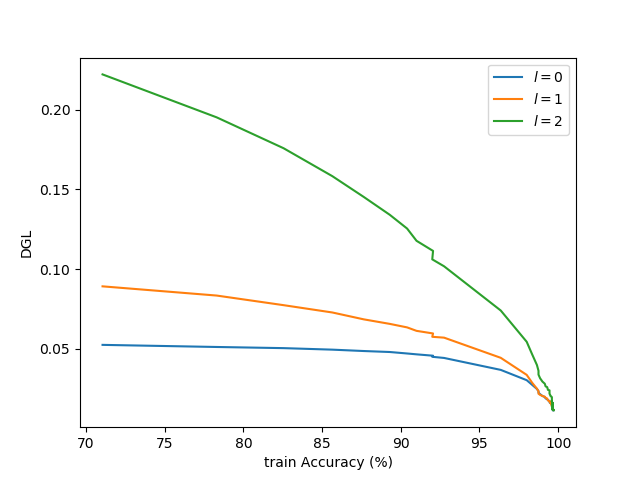

<IPython.core.display.Javascript object>


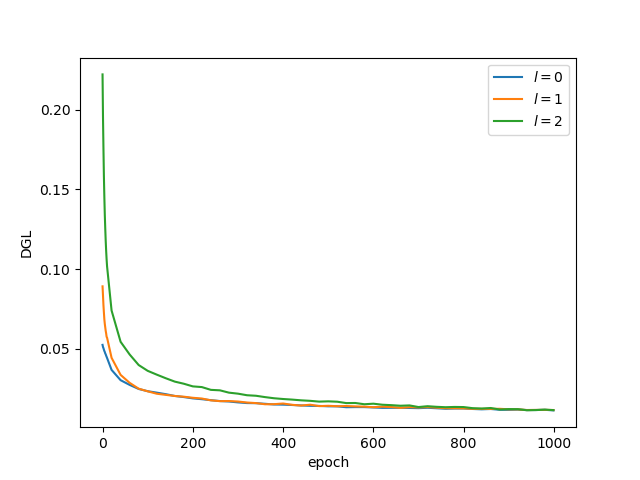

Text(0,0.5,'DGL')

In [51]:
train_losses_df.rename(columns=dict(train_BIE_0='$l=0$', train_BIE_1='$l=1$', train_BIE_2='$l=2$',), inplace=True)
# pytoch 0.4.0 MSE loss divides by the length of the labels vector, we need to correct for that
train_losses_df.iloc[1:].assign(train_loss=train_losses_df.train_loss*2).set_index('train_loss').drop(['epoch','train_acc'] , axis=1).plot()
plt.xlabel('train MSE')
plt.ylabel('DGL')
train_losses_df.iloc[1:].set_index('train_acc').drop(['epoch','train_loss'] , axis=1).plot()
plt.xlabel('train Accuracy (%)')
plt.ylabel('DGL')
# plt.savefig(r'../analysis/monitoring_mnist2k_depth-3_width-20.eps', format='eps')
train_losses_df.iloc[1:].set_index('epoch').drop(['train_loss', 'train_acc'] , axis=1).plot()
plt.ylabel('DGL')

<IPython.core.display.Javascript object>


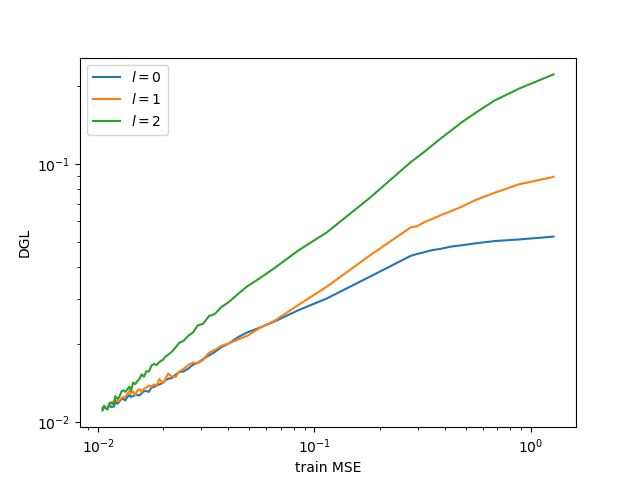

<IPython.core.display.Javascript object>


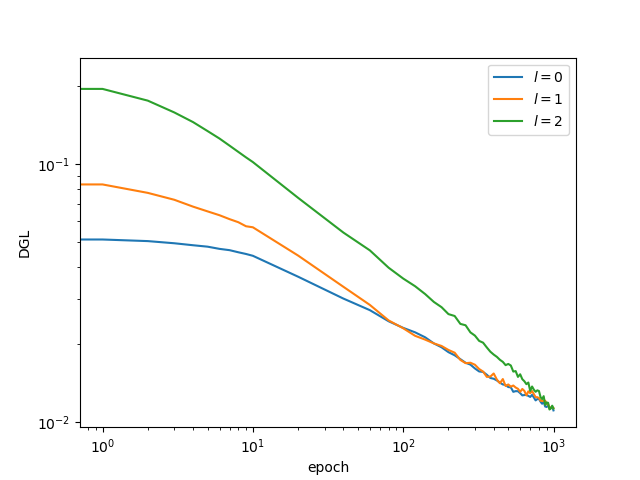

Text(0,0.5,'DGL')

In [81]:
train_losses_df.rename(columns=dict(train_BIE_0='$l=0$', train_BIE_1='$l=1$', train_BIE_2='$l=2$',), inplace=True)
# pytoch 0.4.0 MSE loss divides by the length of the labels vector, we need to correct for that
train_losses_df.iloc[1:].assign(train_loss=train_losses_df.train_loss*2).set_index('train_loss').drop(['epoch','train_acc'] , axis=1).plot(logx=True,logy=True)
plt.xlabel('train MSE')
plt.ylabel('DGL')
train_losses_df.iloc[1:].set_index('epoch').drop(['train_loss', 'train_acc'] , axis=1).plot(logx=True,logy=True)
plt.ylabel('DGL')

<IPython.core.display.Javascript object>


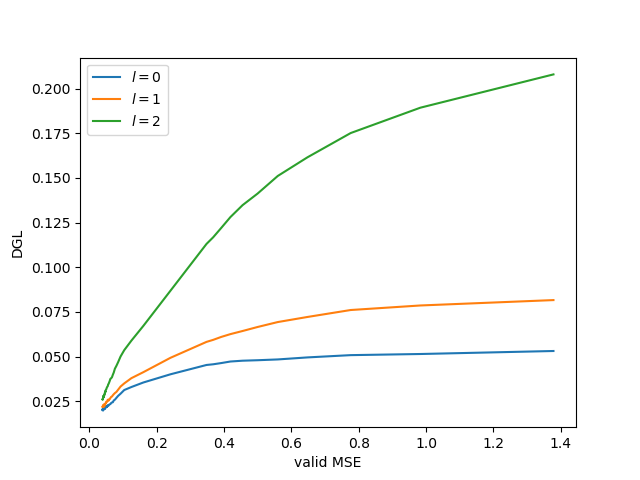

<IPython.core.display.Javascript object>


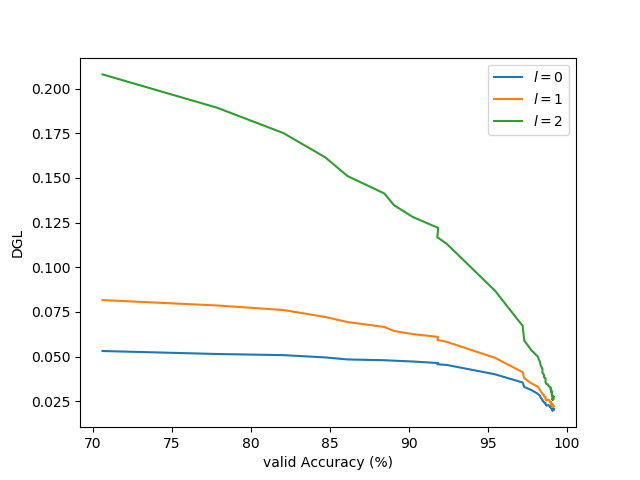

<IPython.core.display.Javascript object>


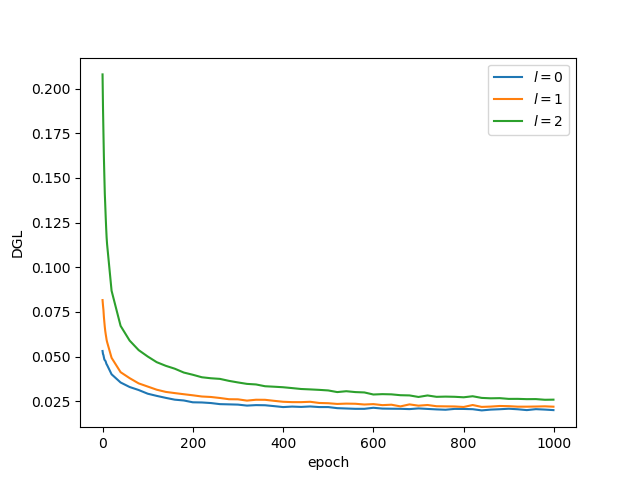

Text(0,0.5,'DGL')

In [53]:
valid_losses_df.rename(columns=dict(valid_BIE_0='$l=0$', valid_BIE_1='$l=1$', valid_BIE_2='$l=2$',), inplace=True)
# pytoch 0.4.0 MSE loss divides by the length of the labels vector, we need to correct for that
valid_losses_df.iloc[1:].assign(valid_loss=valid_losses_df.valid_loss*2).set_index('valid_loss').drop(['epoch','valid_acc'] , axis=1).plot()
plt.xlabel('valid MSE')
plt.ylabel('DGL')
valid_losses_df.iloc[1:].set_index('valid_acc').drop(['epoch','valid_loss'] , axis=1).plot()
plt.xlabel('valid Accuracy (%)')
plt.ylabel('DGL')
# plt.savefig(r'../analysis/monitoring_mnist2k_depth-3_width-20.eps', format='eps')
valid_losses_df.iloc[1:].set_index('epoch').drop(['valid_loss', 'valid_acc'] , axis=1).plot()
plt.ylabel('DGL')

<IPython.core.display.Javascript object>


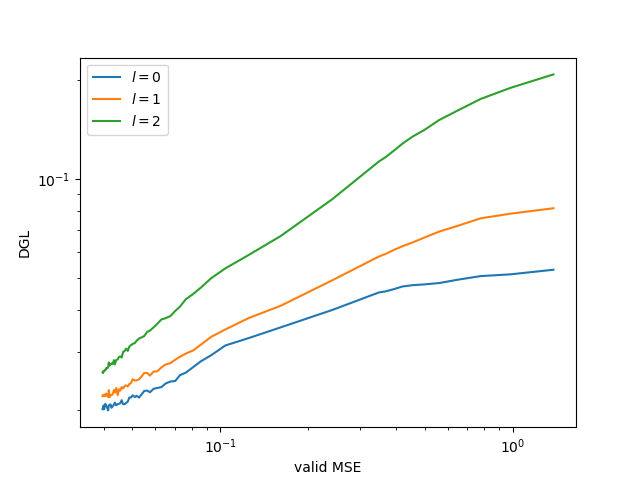

<IPython.core.display.Javascript object>


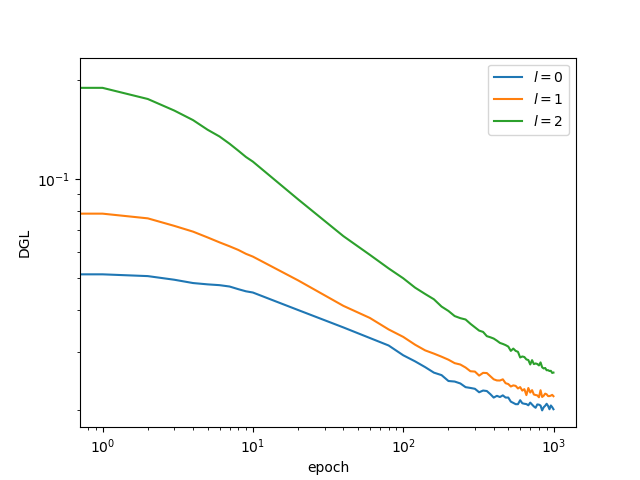

Text(0,0.5,'DGL')

In [54]:
valid_losses_df.rename(columns=dict(valid_BIE_0='$l=0$', valid_BIE_1='$l=1$', valid_BIE_2='$l=2$',), inplace=True)
# pytoch 0.4.1 MSE loss divides by the length of the labels vector, we need to correct for that
valid_losses_df.iloc[1:].assign(valid_loss=valid_losses_df.valid_loss*2).set_index('valid_loss').drop(['epoch','valid_acc'] , axis=1).plot(logx=True,logy=True)
plt.xlabel('valid MSE')
plt.ylabel('DGL')
# plt.savefig(r'../analysis/monitoring_mnist2k_depth-3_width-20.eps', format='eps')
valid_losses_df.iloc[1:].set_index('epoch').drop(['valid_loss', 'valid_acc'] , axis=1).plot(logx=True,logy=True)
plt.ylabel('DGL')

# DGL LEGO (step 4)

In [55]:
for (name,child) in net.layers.named_children(): 
    for param in child.parameters():
        param.requires_grad=True

In [56]:
device=torch.device('cpu')
net.to(device)
dtype=BIE_dtype

In [57]:
torch.manual_seed(train_seed)
np.random.seed(train_seed)
net.apply(weight_init);

In [58]:
lr=0.01
weight_decay=0.0005
max_epochs=50
optimizer_algo='Adam'
final_frac=0.1
full_mb_size=mb_size=500
BIE_eps_acc=1e-4

In [59]:
BIE_loss_fn=BIE_MSE_loss

In [60]:
start_time=time.time()

BIE_eps=[]
for layer_idx in bayesian_trained_layers:

    K_params = K_params_list[layer_idx]
    
    name, layer=get_layer_name(net, layer_idx)
    Ps={
        name:list()
    }
    print('layer_idx:{} {:.1f}s | start training layer {}'.format(layer_idx, time.time() - start_time, name))

    if optimizer_algo == 'SGD':
        optimizer = optim.SGD(layer.parameters(), lr=lr, weight_decay=weight_decay,)
    elif optimizer_algo=='Adam':
        optimizer = optim.Adam(layer.parameters(), lr=lr, weight_decay=weight_decay,)

    trainloader = torch.utils.data.DataLoader(
        train, batch_size=mb_size, shuffle=True, drop_last=True)
    validloader = torch.utils.data.DataLoader(
        valid, batch_size=mb_size, shuffle=True, drop_last=True)
    validloader_iter = cycle(validloader)
    trainloader_iter = cycle(trainloader)

    trainloader_full = torch.utils.data.DataLoader(
        train, batch_size=full_mb_size, shuffle=True, drop_last=True)
    validloader_full = torch.utils.data.DataLoader(
        valid, batch_size=full_mb_size, shuffle=True, drop_last=True)
    validloader_full_iter = cycle(validloader_full)
    trainloader_full_iter = cycle(trainloader_full)

    n_epoch_batches = len(train)//mb_size

    last_epoch=-1
    check_every_epoch=1

    valid_inputs, valid_labels = next(validloader_full_iter)

    valid_losses=[]
    losses=[]

    net_outputs_fn = partial(layer_activations, layer_idx=layer_idx)

    # initial loss before training
    train_inputs, train_labels = next(trainloader_full_iter)
    train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    
    # find the optimal BIE_eps based on gap
    BIE_eps.append(BIE_eps_finder(train_outputs,K_params, device=device, dtype=dtype))
    print('using recommended eps: ',BIE_eps[layer_idx])
    criterion=partial(BIE_MSE_loss, K_params=K_params, device=device, dtype=dtype, eps=BIE_eps[layer_idx])
    
    train_loss=get_loss(criterion, train_labels, train_outputs)
    losses.append((last_epoch,train_loss.item()))

    # initial loss before training
    valid_inputs, valid_labels = next(validloader_full_iter)
    valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    valid_loss=get_loss(criterion, valid_labels, valid_outputs)
    valid_losses.append((last_epoch,valid_loss.item()))

    print(
        'Initial | loss: {:.2}, valid_loss: {:.2},'.format(
            train_loss, 
            valid_loss,
        )
    )

    last_epoch+=1
    try:
        for epoch in range(last_epoch, max_epochs):  # loop over the datasetset multiple times
            running_loss = 0.0
            valid_running_loss = 0.0

            net.train()
            
            for i, local_batch in enumerate(trainloader, 1):#step_iter:
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                loss = get_loss(criterion, *get_bn_labels_preds(local_batch, net, device=device, net_outputs_fn=net_outputs_fn))

                loss.backward()
                
                optimizer.step()

                # print statistics
                running_loss += loss.data.item()

            last_epoch=epoch
            net.eval()

            losses.append((last_epoch, running_loss/i))

            if last_epoch % max_epochs == 10:
                check_every_epoch = np.max((10,check_every_epoch))
            if last_epoch % max_epochs == 20:
                check_every_epoch = np.max((20,check_every_epoch))
            if last_epoch % max_epochs == 100:
                check_every_epoch = np.max((100,check_every_epoch))
            if last_epoch % max_epochs == 200:
                check_every_epoch = np.max((200,check_every_epoch))
            if last_epoch % max_epochs == 1000:
                check_every_epoch = np.max((1000,check_every_epoch))

            if ((last_epoch % max_epochs) == 0) or ((epoch % max_epochs) % check_every_epoch == 0): 

                train_inputs, train_labels = next(trainloader_full_iter)
                train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    

                train_loss=get_loss(criterion, train_labels, train_outputs)
                losses.append((last_epoch, train_loss.item()))
                
                valid_inputs, valid_labels = next(validloader_full_iter)        
                valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
                valid_loss = get_loss(criterion, valid_labels, valid_outputs)
                valid_losses.append((last_epoch,valid_loss.item()))
                valid_loss = valid_losses[-1][1]


                print(
                    'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, L2: {:.2}'
                    .format(
                        iter_idx,
                        time.time() - start_time, 
                        last_epoch, 
                        train_loss, 
                        valid_loss,
                        net.layers[layer_idx].module.weight.pow(2).sum().sqrt().item()
                    )
                )

    except KeyboardInterrupt:
        last_epoch=epoch+1
        print('iter_idx:{} {:.1f}s | epoch:{}, interupting training, wrapping up'.format(iter_idx, time.time() - start_time, last_epoch))
        net.eval()

    train_inputs, train_labels = next(trainloader_full_iter)
    train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)


    train_loss=get_loss(criterion, train_labels, train_outputs)
    losses.append((last_epoch, train_loss.item()))
    
    valid_inputs, valid_labels = next(validloader_full_iter)
    valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)

    valid_loss = get_loss(criterion, *get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn))

    valid_losses.append((last_epoch,valid_loss.item()))
    valid_loss = valid_losses[-1][1]
    
    print(
    'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}'.format(
        iter_idx,
        time.time() - start_time,
        last_epoch, 
        train_loss, 
        valid_loss,
    )
)

layer_idx:0 0.0s | start training layer 0
using recommended eps:  0.2783356628417969
Initial | loss: 0.062, valid_loss: 0.083,
iter_idx:0 0.4s | epoch:0, loss: 0.0098, valid_loss: 0.025, L2: 1e+01
iter_idx:0 0.8s | epoch:1, loss: 0.0048, valid_loss: 0.013, L2: 1e+01
iter_idx:0 1.1s | epoch:2, loss: 0.0064, valid_loss: 0.0036, L2: 1e+01
iter_idx:0 1.4s | epoch:3, loss: 0.0062, valid_loss: 0.017, L2: 9.7
iter_idx:0 1.8s | epoch:4, loss: 0.0036, valid_loss: 0.019, L2: 9.2
iter_idx:0 2.1s | epoch:5, loss: 0.0027, valid_loss: 0.01, L2: 8.7
iter_idx:0 2.6s | epoch:6, loss: 0.0041, valid_loss: 0.0027, L2: 8.3
iter_idx:0 2.9s | epoch:7, loss: 0.0035, valid_loss: 0.016, L2: 7.8
iter_idx:0 3.3s | epoch:8, loss: 0.0018, valid_loss: 0.015, L2: 7.3
iter_idx:0 3.6s | epoch:9, loss: 0.0013, valid_loss: 0.0095, L2: 6.9
iter_idx:0 4.0s | epoch:10, loss: 0.002, valid_loss: 0.002, L2: 6.5
iter_idx:0 7.3s | epoch:20, loss: 0.00052, valid_loss: 0.014, L2: 4.0
iter_idx:0 13.9s | epoch:40, loss: 0.00044, val

## save pretrained layers

In [61]:
pretrained_idxs=bayesian_trained_layers 
pretrain_layers=[get_layer_idx_name_x0(net, layer_idx) for layer_idx in pretrained_idxs]

# Training of the Linear Classifier (step 5)

## Traing using frozen DGL-trained layers

In [62]:
device=torch.device('cuda')
net.to(device);

In [63]:
optimizer_algo='SGD'

In [64]:
mb_size=50
lr=0.001
weight_decay=0.005
max_epochs=1000

In [65]:
full_mb_size=n_valid_samples

In [66]:
retrain_seed=5476
reinit_weights=True

In [67]:
frozen_random_pretrained=False

In [68]:
test_losses=[]
test_accs=[]
final_losses=[]
final_valid_losses=[]
final_accs=[]
final_valid_accs=[]
for permute_layers in [False, True]:

    testloader_full = torch.utils.data.DataLoader(
        test, batch_size=n_test_samples, shuffle=True, drop_last=True,)
    testloader_full_iter = cycle(testloader_full)

    max_layer=len(bayesian_trained_layers)
    last_epoch=-1

    torch.manual_seed(retrain_seed)
    np.random.seed(retrain_seed)
    if reinit_weights:
        net.apply(weight_init)
    pretrained_names=[]
    for layer_idx,name,x0 in pretrain_layers[:max_layer]:
        if not frozen_random_pretrained:
            update_layer_(x0, net, layer_idx, device=device, permute_layer=permute_layers)
        pretrained_names.append(name)

    for (name,child) in net.layers.named_children(): 
        if name in pretrained_names:
            for param in child.parameters():
                param.requires_grad=False
        else:
            for param in child.parameters():
                param.requires_grad=True

    for (name,child) in net.layers.named_children(): 
        for param in child.parameters():
            print((name,param.requires_grad))

    if optimizer_algo == 'SGD':
        optimizer = optim.SGD([p for p in net.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay,)
    elif optimizer_algo=='Adam':
        optimizer = optim.Adam([p for p in net.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay,)

    trainloader = torch.utils.data.DataLoader(
        train, batch_size=mb_size, shuffle=True, drop_last=True,)
    validloader = torch.utils.data.DataLoader(
        valid, batch_size=mb_size, shuffle=True, drop_last=True,)
    validloader_iter = cycle(validloader)
    trainloader_iter = cycle(trainloader)

    trainloader_full = torch.utils.data.DataLoader(
    train, batch_size=full_mb_size, shuffle=True, drop_last=True,)
    validloader_full = torch.utils.data.DataLoader(
        valid, batch_size=full_mb_size, shuffle=True, drop_last=True,)
    validloader_full_iter = cycle(validloader_full)
    trainloader_full_iter = cycle(trainloader_full)

    n_epoch_batches = len(train)//mb_size

    n_classes = net.layers[-1].out_features

    check_every_epoch=1

    criterion=nn.MSELoss()
    net_outputs_fn=None

    start_time=time.time()

    print('iter_idx:{} {:.1f}s | start training, permute_layers: {}'.format(iter_idx, time.time() - start_time,permute_layers))
    valid_losses=[]
    losses=[]
    lrs=[]
    lr_epochs=[]
    try:

        # initial loss before training
        train_inputs, train_labels = next(trainloader_full_iter)
        train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
        train_loss=get_loss(criterion, train_labels, train_outputs)
        losses.append((last_epoch,train_loss.item()))

        # initial loss before training
        valid_inputs, valid_labels = next(validloader_full_iter)
        valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
        valid_loss=get_loss(criterion, valid_labels, valid_outputs)
        valid_losses.append((last_epoch,valid_loss.item()))
        print(
            'Initial | loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
                train_loss, 
                valid_loss,
                accuracy(train_labels, train_outputs),
                accuracy(valid_labels, valid_outputs),
            )
        )

        last_epoch+=1
        for epoch in range(last_epoch, max_epochs):  # loop over the datasetset multiple times
            running_loss = 0.0
            valid_running_loss = 0.0

            net.train()
            T_epoch = epoch
            for i, local_batch in enumerate(trainloader, 1):

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize

                loss = get_loss(
                    criterion,
                    *get_bn_labels_preds(local_batch, net, device=device, net_outputs_fn=net_outputs_fn)
                )

                loss.backward()

                optimizer.step()

                # print statistics
                running_loss += loss.data.item()

            last_epoch=epoch
            net.eval()

            losses.append((last_epoch, running_loss/i))


            if last_epoch % max_epochs == 10:
                check_every_epoch = np.max((10,check_every_epoch))
            if last_epoch % max_epochs == 20:
                check_every_epoch = np.max((20,check_every_epoch))
            if last_epoch % max_epochs == 100:
                check_every_epoch = np.max((100,check_every_epoch))

            if ((last_epoch % max_epochs) == 0) or ((epoch % max_epochs) % check_every_epoch == 0): 
                valid_inputs, valid_labels = next(validloader_full_iter)        
                valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
                valid_loss = get_loss(criterion, valid_labels, valid_outputs)
                valid_losses.append((last_epoch,valid_loss.item()))
                valid_loss = valid_losses[-1][1]


                train_inputs, train_labels = next(trainloader_full_iter)
                train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
                train_loss = get_loss(criterion, train_labels, train_outputs).item()

                print(
                    'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
                        iter_idx,
                        time.time() - start_time, 
                        last_epoch, 
                        train_loss, 
                        valid_loss,
                        accuracy(train_labels, train_outputs),
                        accuracy(valid_labels, valid_outputs),
                    )
                )



    except KeyboardInterrupt:
        last_epoch=epoch+1
        print('iter_idx:{} {:.1f}s | epoch:{}, interupting training, wrapping up'.format(iter_idx, time.time() - start_time, last_epoch))
        net.eval()

    valid_inputs, valid_labels = next(validloader_full_iter)
    valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    valid_loss = get_loss(criterion, valid_labels, valid_outputs)
    valid_losses.append((last_epoch,valid_loss.item()))
    valid_loss = valid_losses[-1][1]
    final_valid_losses.append(valid_loss)

    train_inputs, train_labels = next(trainloader_full_iter)
    train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    train_loss = get_loss(criterion, train_labels, train_outputs).item()
    final_losses.append(train_loss)

    print(
        'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
            iter_idx,
            time.time() - start_time,
            last_epoch, 
            train_loss, 
            valid_loss,
            accuracy(train_labels, train_outputs),
            accuracy(valid_labels, valid_outputs),
        )
    )

    final_accs.append(accuracy(train_labels, train_outputs))
    final_valid_accs.append(accuracy(valid_labels, valid_outputs))

    test_inputs, test_labels = next(testloader_full_iter)
    test_labels, test_outputs = get_bn_labels_preds((test_inputs, test_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    test_loss = get_loss(criterion, test_labels, test_outputs)
    test_losses.append((permute_layers, max_layer,test_loss.item()))
    test_loss = test_losses[-1][1]

    test_accs.append(accuracy(test_labels, test_outputs))

('0', False)
('0', False)
('1', False)
('1', False)
('2', False)
('2', False)
('3', True)
('3', True)
iter_idx:0 0.0s | start training, permute_layers: False
Initial | loss: 0.52, valid_loss: 0.52, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.1s | epoch:0, loss: 0.5, valid_loss: 0.5, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.1s | epoch:1, loss: 0.48, valid_loss: 0.48, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.2s | epoch:2, loss: 0.46, valid_loss: 0.46, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.2s | epoch:3, loss: 0.44, valid_loss: 0.44, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.2s | epoch:4, loss: 0.42, valid_loss: 0.42, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.3s | epoch:5, loss: 0.41, valid_loss: 0.41, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.3s | epoch:6, loss: 0.39, valid_loss: 0.39, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.4s | epoch:7, loss: 0.38, valid_loss: 0.38, acc: 50.00, valid_acc: 50.00
iter_idx:0 0.4s | epoch:8, loss: 0.37, valid_loss: 0.37, acc: 50.00, valid_acc: 50.00
i

In [69]:
final_retrain_losses_df=pd.concat(
    [
        pd.DataFrame(test_losses,columns=['permute_layers','max_layer','test_loss']),
        pd.DataFrame(test_accs, columns=['test_accs']),
        pd.DataFrame(final_losses, columns=['train_losses']),
        pd.DataFrame(final_accs, columns=['train_accs']),
        pd.DataFrame(final_valid_losses, columns=['valid_losses']),
        pd.DataFrame(final_valid_accs, columns=['valid_accs']),
        
    ],
    axis=1,
)

final_retrain_losses_df.loc[-1]=[False,-1,final_sgd_test_loss, final_sgd_test_acc, final_sgd_loss, final_sgd_acc, final_sgd_valid_loss, final_sgd_valid_acc,]

## retrain - frozen random

In [70]:
device=torch.device('cuda')
net.to(device);

In [71]:
optimizer_algo='SGD'

In [72]:
mb_size=50
lr=0.001
weight_decay=0.005
max_epochs=1000

In [73]:
full_mb_size=n_valid_samples

In [74]:
retrain_seed=5476
reinit_weights=True

In [75]:
frozen_random_pretrained=True
permute_layers=False

In [76]:
test_losses=[]
test_accs=[]
final_losses=[]
final_valid_losses=[]
final_accs=[]
final_valid_accs=[]


testloader_full = torch.utils.data.DataLoader(
    test, batch_size=n_test_samples, shuffle=True, drop_last=True,)
testloader_full_iter = cycle(testloader_full)

max_layer=len(bayesian_trained_layers)
last_epoch=-1

torch.manual_seed(retrain_seed)
np.random.seed(retrain_seed)
if reinit_weights:
    net.apply(weight_init)
pretrained_names=[]
for layer_idx,name,x0 in pretrain_layers[:max_layer]:
    pretrained_names.append(name)

for (name,child) in net.layers.named_children(): 
    if name in pretrained_names:
        for param in child.parameters():
            param.requires_grad=False
    else:
        for param in child.parameters():
            param.requires_grad=True

for (name,child) in net.layers.named_children(): 
    for param in child.parameters():
        print((name,param.requires_grad))

if optimizer_algo == 'SGD':
    optimizer = optim.SGD([p for p in net.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay,)
elif optimizer_algo=='Adam':
    optimizer = optim.Adam([p for p in net.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay,)

trainloader = torch.utils.data.DataLoader(
    train, batch_size=mb_size, shuffle=True, drop_last=True,)
validloader = torch.utils.data.DataLoader(
    valid, batch_size=mb_size, shuffle=True, drop_last=True,)
validloader_iter = cycle(validloader)
trainloader_iter = cycle(trainloader)

trainloader_full = torch.utils.data.DataLoader(
train, batch_size=full_mb_size, shuffle=True, drop_last=True,)
validloader_full = torch.utils.data.DataLoader(
    valid, batch_size=full_mb_size, shuffle=True, drop_last=True,)
validloader_full_iter = cycle(validloader_full)
trainloader_full_iter = cycle(trainloader_full)

n_epoch_batches = len(train)//mb_size

n_classes = net.layers[-1].out_features

check_every_epoch=1

criterion=nn.MSELoss()
net_outputs_fn=None

start_time=time.time()

print('iter_idx:{} {:.1f}s | start training, permute_layers: {}'.format(iter_idx, time.time() - start_time,permute_layers))

valid_losses=[]
losses=[]
try:

    # initial loss before training
    train_inputs, train_labels = next(trainloader_full_iter)
    train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    train_loss=get_loss(criterion, train_labels, train_outputs)
    losses.append((last_epoch,train_loss.item()))

    # initial loss before training
    valid_inputs, valid_labels = next(validloader_full_iter)
    valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
    valid_loss=get_loss(criterion, valid_labels, valid_outputs)
    valid_losses.append((last_epoch,valid_loss.item()))
    print(
        'Initial | loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
            train_loss, 
            valid_loss,
            accuracy(train_labels, train_outputs),
            accuracy(valid_labels, valid_outputs),
        )
    )

    last_epoch+=1
    for epoch in range(last_epoch, max_epochs):  # loop over the datasetset multiple times
        running_loss = 0.0
        valid_running_loss = 0.0

        net.train()
        T_epoch = epoch
        for i, local_batch in enumerate(trainloader, 1):


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize

            loss = get_loss(
                criterion,
                *get_bn_labels_preds(local_batch, net, device=device, net_outputs_fn=net_outputs_fn)
            )

            loss.backward()
            
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()

        last_epoch=epoch
        net.eval()

        losses.append((last_epoch, running_loss/i))


        if last_epoch % max_epochs == 10:
            check_every_epoch = np.max((10,check_every_epoch))
        if last_epoch % max_epochs == 20:
            check_every_epoch = np.max((20,check_every_epoch))
        if last_epoch % max_epochs == 100:
            check_every_epoch = np.max((100,check_every_epoch))

        if ((last_epoch % max_epochs) == 0) or ((epoch % max_epochs) % check_every_epoch == 0): 
            valid_inputs, valid_labels = next(validloader_full_iter)        
            valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
            valid_loss = get_loss(criterion, valid_labels, valid_outputs)
            valid_losses.append((last_epoch,valid_loss.item()))
            valid_loss = valid_losses[-1][1]

            train_inputs, train_labels = next(trainloader_full_iter)
            train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
            train_loss = get_loss(criterion, train_labels, train_outputs).item()

            print(
                'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
                    iter_idx,
                    time.time() - start_time, 
                    last_epoch, 
                    train_loss, 
                    valid_loss,
                    accuracy(train_labels, train_outputs),
                    accuracy(valid_labels, valid_outputs),
                )
            )


except KeyboardInterrupt:
    last_epoch=epoch+1
    print('iter_idx:{} {:.1f}s | epoch:{}, interupting training, wrapping up'.format(iter_idx, time.time() - start_time, last_epoch))
    net.eval()

valid_inputs, valid_labels = next(validloader_full_iter)
valid_labels, valid_outputs = get_bn_labels_preds((valid_inputs, valid_labels), net, device=device, net_outputs_fn=net_outputs_fn)
valid_loss = get_loss(criterion, valid_labels, valid_outputs)
valid_losses.append((last_epoch,valid_loss.item()))
valid_loss = valid_losses[-1][1]
final_valid_losses.append(valid_loss)

train_inputs, train_labels = next(trainloader_full_iter)
train_labels, train_outputs = get_bn_labels_preds((train_inputs, train_labels), net, device=device, net_outputs_fn=net_outputs_fn)
train_loss = get_loss(criterion, train_labels, train_outputs).item()
final_losses.append(train_loss)

print(
    'iter_idx:{} {:.1f}s | epoch:{}, loss: {:.2}, valid_loss: {:.2}, acc: {:.2f}, valid_acc: {:.2f}'.format(
        iter_idx,
        time.time() - start_time,
        last_epoch, 
        train_loss, 
        valid_loss,
        accuracy(train_labels, train_outputs),
        accuracy(valid_labels, valid_outputs),
    )
)

final_accs.append(accuracy(train_labels, train_outputs))
final_valid_accs.append(accuracy(valid_labels, valid_outputs))

test_inputs, test_labels = next(testloader_full_iter)
test_labels, test_outputs = get_bn_labels_preds((test_inputs, test_labels), net, device=device, net_outputs_fn=net_outputs_fn)
test_loss = get_loss(criterion, test_labels, test_outputs)
test_losses.append((permute_layers, max_layer,test_loss.item()))
test_loss = test_losses[-1][1]

test_accs.append(accuracy(test_labels, test_outputs))

('0', False)
('0', False)
('1', False)
('1', False)
('2', False)
('2', False)
('3', True)
('3', True)
iter_idx:0 0.0s | start training, permute_layers: False
Initial | loss: 1.7e+01, valid_loss: 1.7e+01, acc: 49.95, valid_acc: 49.90
iter_idx:0 0.1s | epoch:0, loss: 2.4, valid_loss: 2.5, acc: 47.05, valid_acc: 46.05
iter_idx:0 0.1s | epoch:1, loss: 1.9, valid_loss: 1.9, acc: 46.00, valid_acc: 46.15
iter_idx:0 0.1s | epoch:2, loss: 1.6, valid_loss: 1.6, acc: 46.80, valid_acc: 47.70
iter_idx:0 0.2s | epoch:3, loss: 1.4, valid_loss: 1.4, acc: 48.40, valid_acc: 49.00
iter_idx:0 0.2s | epoch:4, loss: 1.2, valid_loss: 1.2, acc: 49.95, valid_acc: 49.75
iter_idx:0 0.3s | epoch:5, loss: 1.1, valid_loss: 1.1, acc: 51.65, valid_acc: 51.40
iter_idx:0 0.3s | epoch:6, loss: 0.97, valid_loss: 0.97, acc: 52.60, valid_acc: 52.35
iter_idx:0 0.3s | epoch:7, loss: 0.88, valid_loss: 0.88, acc: 53.60, valid_acc: 53.45
iter_idx:0 0.4s | epoch:8, loss: 0.81, valid_loss: 0.8, acc: 54.80, valid_acc: 54.20
iter_i

In [77]:
final_frozen_random_retrain_losses_df=pd.concat(
    [
        pd.DataFrame(test_losses,columns=['permute_layers','max_layer','test_loss']),
        pd.DataFrame(test_accs, columns=['test_accs']),
        pd.DataFrame(final_losses, columns=['train_losses']),
        pd.DataFrame(final_accs, columns=['train_accs']),
        pd.DataFrame(final_valid_losses, columns=['valid_losses']),
        pd.DataFrame(final_valid_accs, columns=['valid_accs']),
        
    ],
    axis=1,
)

# train/val/test scores

In [78]:
# NOTE - where permute_layers is True, the frozen DGL-trained layers were permuted before the linear classifier was trained, as an additional base-line for comparison.
# NOTE - the row with max_layer -1 is the end-to-end optimization of step 1.
# NOTE - all MSE scores are MSE/2. since pytorch 0.4.0 divides the MSE loss by the length of the target vectors
display(final_retrain_losses_df)

,permute_layers,max_layer,test_loss,test_accs,train_losses,train_accs,valid_losses,valid_accs
0,False,3,0.026646,99.214055,0.021187,100.00,0.024843,99.45
1,True,3,0.249276,59.038373,0.249135,61.55,0.249215,61.35
-1,False,-1,0.018029,98.613037,0.005238,99.70,0.019786,99.10


In [79]:
display(final_frozen_random_retrain_losses_df)

,permute_layers,max_layer,test_loss,test_accs,train_losses,train_accs,valid_losses,valid_accs
0,False,3,0.075994,93.527508,0.082748,91.95,0.077405,93.25
